In [1]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=f76b0c00e3d4ad24b3225abc8ef41d1eed7b5b2ffb1961143ba5f0de1ff32d74
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=9d28f984df97a88ae06b06ab2e0dd

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import os

from PIL import Image,ImageDraw

class corrosion_dataset(Dataset):
  
    CLASSES = ['corrosion']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.images_fps = images_dir
        self.masks_fps = masks_dir
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        mask = cv2.imread(self.masks_fps[i])[:,:,2]  # masks are stored in R channel
        corrosion = (mask != 0).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

In [2]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_to_train_imgs = "/content/drive/MyDrive/corrosion_dataset/JPEGImages/"
path_to_train_masks =  "/content/drive/MyDrive/corrosion_dataset/SegmentationClassPNG/"

images_train = sorted([path_to_train_imgs + filename for filename in os.listdir(path_to_train_imgs)])
masks_train = sorted([path_to_train_masks + filename for filename in os.listdir(path_to_train_masks)])

In [5]:
dataset = corrosion_dataset(images_train, masks_train, classes=['corrosion'])
print(len(dataset))

253


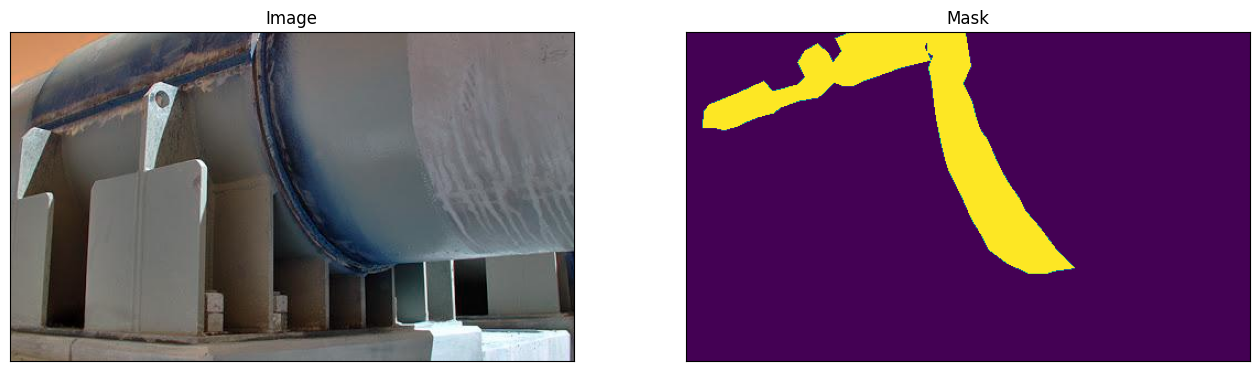

(299, 512, 3)

In [6]:
image, mask = dataset[28] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)
image.shape

In [7]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [
        albu.Resize(224,224),
        albu.Flip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        albu.Resize(224,224),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
        # albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

(224, 224, 3)


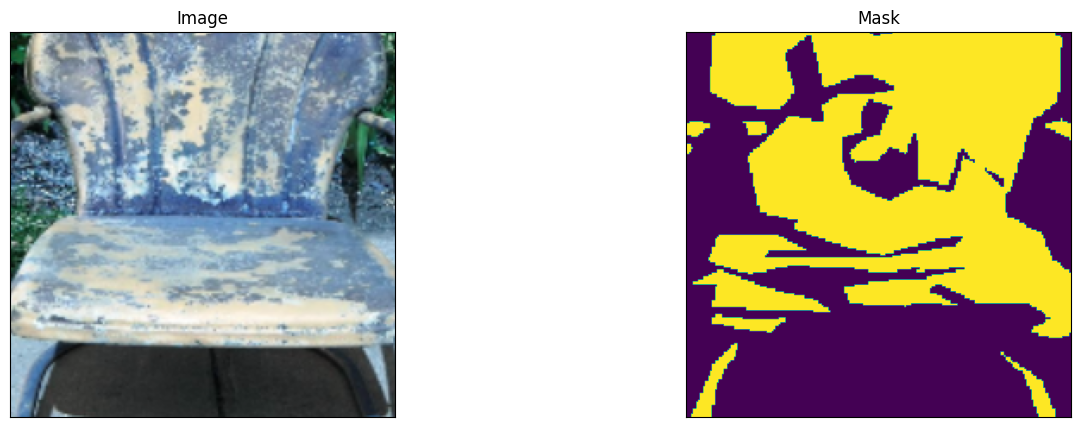

(224, 224, 3)


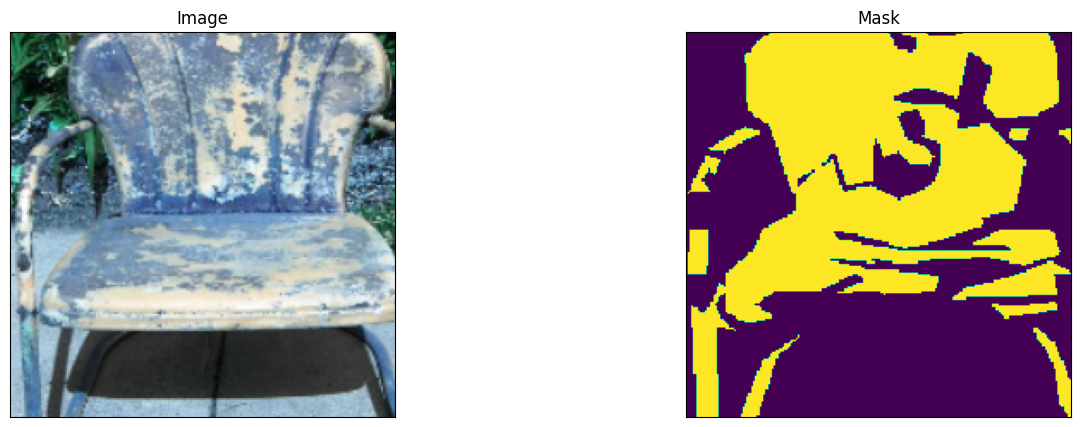

(224, 224, 3)


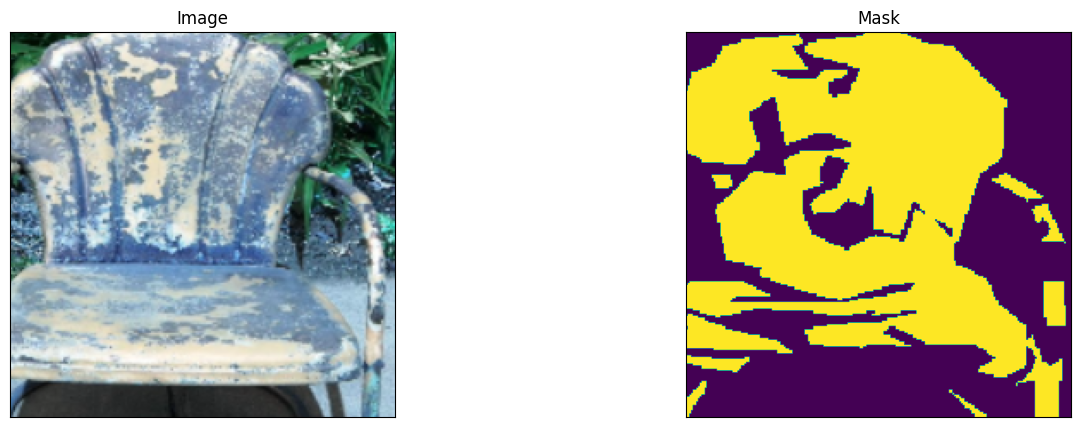

In [8]:
augmented_dataset = corrosion_dataset(
    images_train, 
    masks_train, 
    augmentation=get_training_augmentation(), 
    classes=['corrosion'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    print(image.shape)
    visualize(image=image, mask=mask.squeeze())

In [9]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=ce6a0cad2dd23e8d2ef4814919500a53ccd844fd60785157fcfce5501647d2f3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=eab55325732c7fa546fa47e88df35

In [10]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

import torch
import numpy as np

import segmentation_models_pytorch as smp

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['corrosion']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


train_dataset = corrosion_dataset(
    images_train, 
    masks_train, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 38.1MB/s]


In [11]:
import segmentation_models_pytorch.utils

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.AdamW([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [12]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
max_score = 0

for i in range(0, 50):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    # valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    # if max_score < valid_logs['iou_score']:
    #     max_score = valid_logs['iou_score']
    #     torch.save(model, './best_model.pth')
    #     print('Model saved! Score: ', max_score)
        
    if i == 35:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

torch.save(model, './best_model.pth')


Epoch: 0
train: 100%|██████████| 64/64 [01:07<00:00,  1.06s/it, dice_loss - -0.7617, iou_score - -10.3]

Epoch: 1
train: 100%|██████████| 64/64 [00:11<00:00,  5.40it/s, dice_loss - -0.9056, iou_score - 4.317]

Epoch: 2
train: 100%|██████████| 64/64 [00:12<00:00,  5.32it/s, dice_loss - -0.9298, iou_score - -10.4]

Epoch: 3
train: 100%|██████████| 64/64 [00:11<00:00,  5.37it/s, dice_loss - -0.9207, iou_score - 1.727]

Epoch: 4
train: 100%|██████████| 64/64 [00:10<00:00,  6.11it/s, dice_loss - -0.947, iou_score - -9.498]

Epoch: 5
train: 100%|██████████| 64/64 [00:11<00:00,  5.65it/s, dice_loss - -0.9859, iou_score - -15.5]

Epoch: 6
train: 100%|██████████| 64/64 [00:12<00:00,  5.32it/s, dice_loss - -0.9682, iou_score - -2.771]

Epoch: 7
train: 100%|██████████| 64/64 [00:12<00:00,  5.30it/s, dice_loss - -0.9817, iou_score - 7.797]

Epoch: 8
train: 100%|██████████| 64/64 [00:11<00:00,  5.73it/s, dice_loss - -0.9856, iou_score - -8.302]

Epoch: 9
train: 100%|██████████| 64/64 [00:10<00:00,

In [15]:
best_model = torch.load('./best_model.pth')

In [16]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(train_loader)

valid: 100%|██████████| 64/64 [00:10<00:00,  6.02it/s, dice_loss - -0.9688, iou_score - 27.26]


In [17]:
class test_corrosion_dataset(Dataset):
    
    CLASSES = ['corrosion']
    
    def __init__(
            self, 
            images_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.images_fps = images_dir
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']

        return image
        
    def __len__(self):
        return len(self.images_fps)

In [18]:
test_dataset = test_corrosion_dataset(
    images_train, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
showset = test_corrosion_dataset(images_train, classes=CLASSES)

(760, 570, 3)
(760, 570)


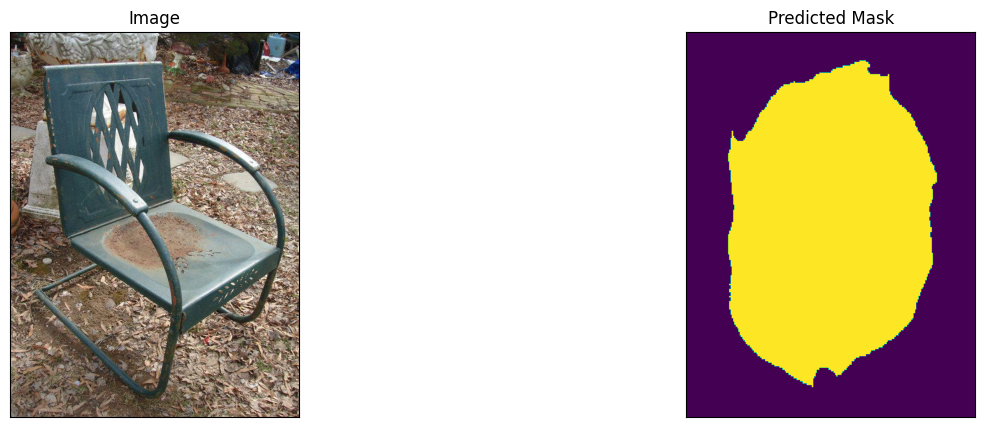

(760, 570)
(760, 570)


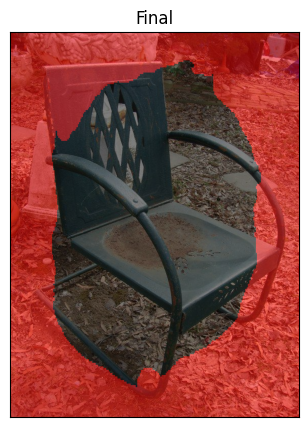

In [44]:
image_vis = showset[22]
image = test_dataset[22]
print(image_vis.shape)
h, w = image_vis.shape[:2]

model.eval()
with torch.no_grad():
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    out = model(x_tensor).squeeze().cpu().numpy().round()
    out = cv2.resize(out, (w, h)).astype, ('uint8')
    print(out.shape)

visualize(
        image=image_vis, 
        predicted_mask=out
    )

ret,thresh = cv2.threshold(out, 0.5, 255, cv2.THRESH_BINARY_INV)
print(thresh.shape)
pure = np.zeros(thresh.shape).astype('uint8')
print(pure.shape)
out3 = cv2.merge((thresh, pure, pure))
res = cv2.addWeighted(image_vis,0.5,out3,0.5,0)
visualize(final=res)